In [1]:
import tellurium as te
import numpy as np

#antimony model
modelfile = 'https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL6615119181/2/BIOMD0000000010_url.xml'

r = te.loadSBMLModel(modelfile)
r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))
parameter_values = r.getGlobalParameterValues()

/opt/conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning:

A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2



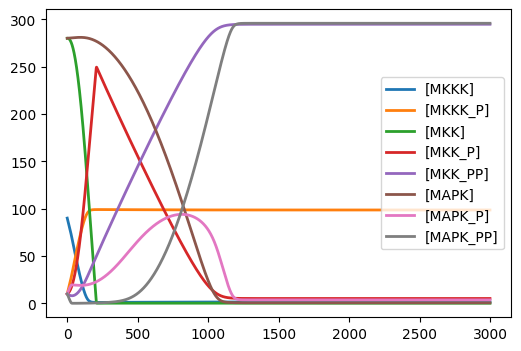

In [2]:
new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
r.model.setGlobalParameterValues(new_parameter_values)

result = r.simulate(0, 3000, 5000)
r.reset()
r.plot(result)

In [262]:
result[:,1:].__array__()

array([[9.00000000e+01, 1.00000000e+01, 2.80000000e+02, ...,
        2.80000000e+02, 1.00000000e+01, 1.00000000e+01],
       [8.96401107e+01, 1.03598893e+01, 2.80023506e+02, ...,
        2.80004827e+02, 1.02268623e+01, 9.76831028e+00],
       [8.92801499e+01, 1.07198501e+01, 2.80041869e+02, ...,
        2.80009781e+02, 1.04531667e+01, 9.53705254e+00],
       ...,
       [1.40038821e+00, 9.85996118e+01, 1.21121918e-01, ...,
        5.41412109e-01, 3.64081117e+00, 2.95817777e+02],
       [1.40038821e+00, 9.85996118e+01, 1.21121918e-01, ...,
        5.41412109e-01, 3.64081117e+00, 2.95817777e+02],
       [1.40038821e+00, 9.85996118e+01, 1.21121918e-01, ...,
        5.41412109e-01, 3.64081117e+00, 2.95817777e+02]])

In [273]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = [i*10 for i in parameters]
        self.lowerb = [i/10 for i in parameters]
        self.r = None
        
    def fitness(self, x):
        # if self.r is None:
        #     self.r = te.loadSBMLModel(self.model)
        #     self.r = te.loadSBMLModel(self.r.getParamPromotedSBML(self.r.getSBML()))
        def _fitness(x,R):
            try:
                results = R.simulate(0, 3000, 5000)[:,1:].__array__()
                return self._residual(results,self.data,5000)
            except:
                return [0]
            
        return _fitness(x,ipp.Reference('R'))

    def _residual(self,results,data,points):
        md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
        mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
        denom = np.ones(data.shape)
        return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]

    def get_bounds(self):
        return (self.lowerb, self.upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [245]:
import pygmo as pg

class my_island(pg.ipyparallel_island):
    pg.ipyparallel_island._view = None
    def init_view(client_args=[], client_kwargs={}, view_args=[], view_kwargs={}):
        with pg.ipyparallel_island._view_lock:
            if pg.ipyparallel_island._view is None:
                # Create the new view.
                from ipyparallel import Client
                my_island.rc = Client(**client_kwargs)
                my_island.rc[:].use_cloudpickle()
                pg.ipyparallel_island._view = my_island.rc.load_balanced_view(*view_args, **view_kwargs)
    def get_name(self):
        return "My island!"
    
udi = my_island()
udi.init_view(client_kwargs={'profile':'cheme-ecfers'})

In [268]:
load_model = """
import tellurium as te
R = te.loadSBMLModel(modelfile)
R = te.loadSBMLModel(R.getParamPromotedSBML(R.getSBML()))
"""
udi.rc[:].push({'modelfile':modelfile})
udi.rc[:].execute(load_model, block=True)

<AsyncResult(execute): finished>

In [281]:
import pygmo as pg
a_cstrs_sa = pg.algorithm(pg.cmaes(gen = 10, sigma0=0.3))
p_toy = pg.problem(SBMLGlobalFit(model = modelfile, data = result[:,1:].__array__(), parameters=parameter_values, settings=None))
archi = pg.archipelago(n=3,algo=a_cstrs_sa, prob=p_toy, pop_size=10, udi = udi)

In [285]:
archi

Number of islands: 3
Topology: Unconnected
Migration type: point-to-point
Migrant handling policy: preserve
Status: idle

Islands summaries:

	#  Type        Algo                                                        Prob                                    Size  Status  
	---------------------------------------------------------------------------------------------------------------------------------
	0  My island!  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Global Fitting of Multiple SBML Models  10    idle    
	1  My island!  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Global Fitting of Multiple SBML Models  10    idle    
	2  My island!  CMA-ES: Covariance Matrix Adaptation Evolutionary Strategy  Global Fitting of Multiple SBML Models  10    idle    

In [283]:
archi.evolve(1)

In [284]:
archi.wait_check()

In [286]:
archi[0]

Island name: My island!
	C++ class name: pybind11::object

	Status: idle

Extra info:
	Queue status:
	
	(unassigned, 0)
	(0, {'queue': 0, 'completed': 48, 'tasks': 0})
	(1, {'queue': 0, 'completed': 48, 'tasks': 0})
	(2, {'queue': 0, 'completed': 48, 'tasks': 0})
	(3, {'queue': 0, 'completed': 48, 'tasks': 0})
	(4, {'queue': 0, 'completed': 48, 'tasks': 0})
	(5, {'queue': 0, 'completed': 48, 'tasks': 0})
	(6, {'queue': 0, 'completed': 48, 'tasks': 0})
	(7, {'queue': 0, 'completed': 48, 'tasks': 0})
	(8, {'queue': 0, 'completed': 48, 'tasks': 0})
	(9, {'queue': 0, 'completed': 48, 'tasks': 0})
	(10, {'queue': 0, 'completed': 48, 'tasks': 0})
	(11, {'queue': 0, 'completed': 48, 'tasks': 0})
	(12, {'queue': 0, 'completed': 48, 'tasks': 0})
	(13, {'queue': 0, 'completed': 48, 'tasks': 0})
	(14, {'queue': 0, 'completed': 48, 'tasks': 0})
	(15, {'queue': 0, 'completed': 48, 'tasks': 0})
	(16, {'queue': 0, 'completed': 48, 'tasks': 0})
	(17, {'queue': 0, 'completed': 48, 'tasks': 0})
	(18, {'